## CSE 351 Course Project
## Title: What makes people in a country happy?

### Submission Date: July 3rd, 2025
### Name: Joohyoung Jun

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Load data

data_2015 = pd.read_csv("2015.csv")
data_2016 = pd.read_csv("2016.csv")
data_2017 = pd.read_csv("2017.csv")
data_2018 = pd.read_csv("2018.csv")
data_2019 = pd.read_csv("2019.csv")

In [3]:
# clean method

def clean(data, year, columns):
    data = data.rename(columns=columns)
    data['Year'] = year
    return data

In [4]:
# clean and merge all years into a single data
# in order to analyze all years consistently in one place.

data_2015 = clean(data_2015, "2015", {
    "Country": "Country",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP",
    "Family": "Support",
    "Health (Life Expectancy)": "Health",
    "Freedom": "Freedom"
})

data_2016 = clean(data_2016, "2016", {
    "Country": "Country",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP",
    "Family": "Support",
    "Health (Life Expectancy)": "Health",
    "Freedom": "Freedom"
})

data_2017 = clean(data_2017, "2017", {
    "Country": "Country",
    "Happiness.Score": "Score",
    "Economy..GDP.per.Capita.": "GDP",
    "Family": "Support",
    "Health..Life.Expectancy.": "Health",
    "Freedom": "Freedom"
})

data_2018 = clean(data_2018, "2018", {
    "Country or region": "Country",
    "Score": "Score",
    "GDP per capita": "GDP",
    "Social support": "Support",
    "Healthy life expectancy": "Health",
    "Freedom to make life choices": "Freedom"
})

data_2019 = clean(data_2019, "2019", {
    "Country or region": "Country",
    "Score": "Score",
    "GDP per capita": "GDP",
    "Social support": "Support",
    "Healthy life expectancy": "Health",
    "Freedom to make life choices": "Freedom"
})

# merge all year data into one
data = pd.concat([data_2015, data_2016, data_2017, data_2018, data_2019])

# drop rows with missing value in order to prevent error
data = data.dropna(subset=["Score", "GDP", "Support", "Health", "Freedom"])



In [5]:
print(data[["Year", "Score"]].groupby("Year").count())


      Score
Year       
2015    158
2016    157
2017    155
2018    156
2019    156


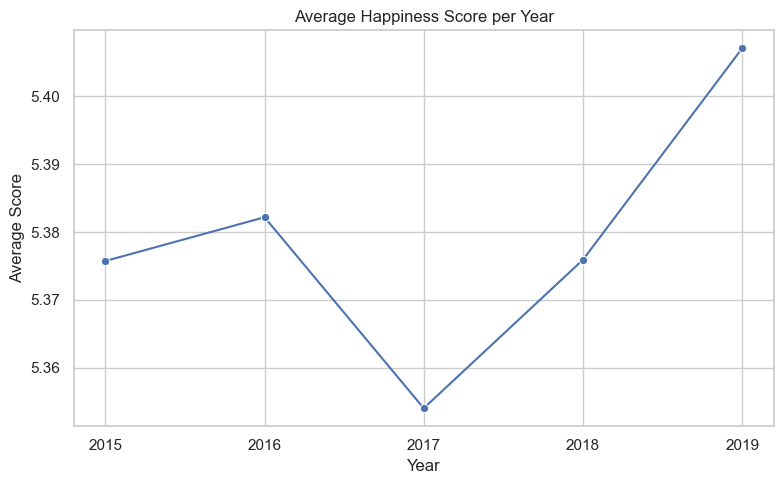

In [6]:
# EDA 
# Average Happiness Score per Year
# (2015-2016): Increase
# (2016-2017): Decrease
# (2017-2018): Increase
# (2018-2019): Increase
# Overall, the happiness score increases. 

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=data.groupby("Year", as_index=False)["Score"].mean(),
    x="Year", 
    y="Score", 
    marker="o"
)
plt.title("Average Happiness Score per Year")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()

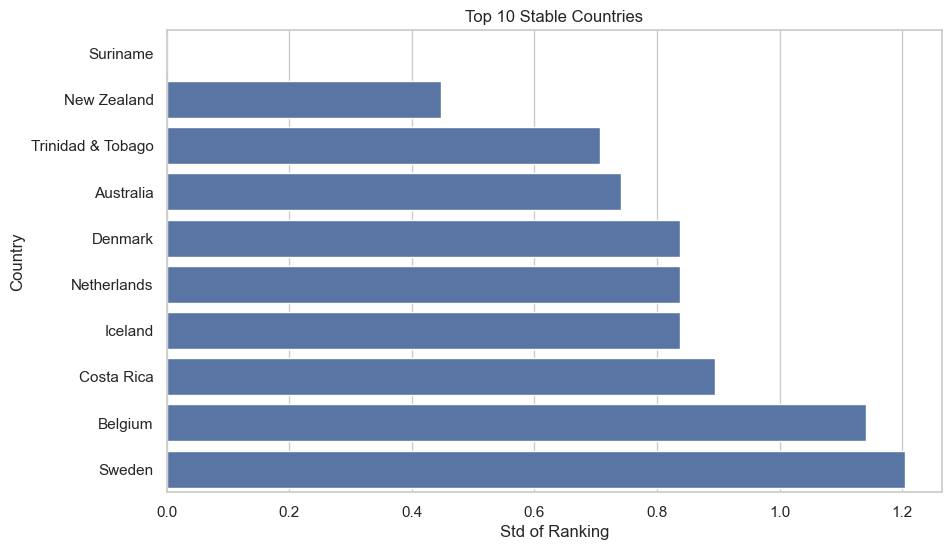

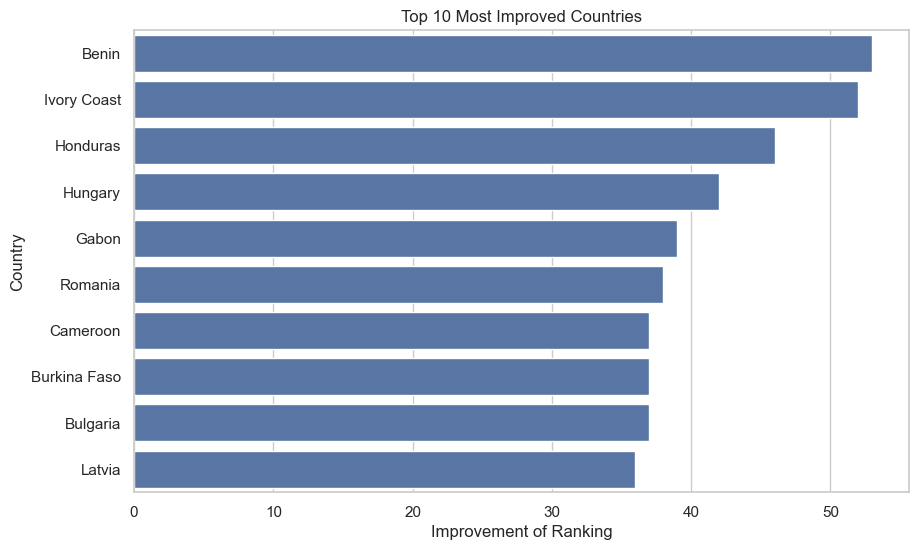

In [7]:
# EDA
# Stable/Improved ranking 
ranking_data = data.copy()
ranking_data["Rank"] = ranking_data.groupby("Year")["Score"].rank(ascending=False)
ranking_pivot = ranking_data.pivot(index="Country", columns="Year", values="Rank")
ranking_pivot["std"] = ranking_pivot.std(axis=1)
ranking_pivot["improvement"] = ranking_pivot["2015"] - ranking_pivot["2019"]

# Top 10 Stable countries
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ranking_pivot["std"].sort_values(ascending=True).head(10),
    y=ranking_pivot["std"].sort_values(ascending=True).head(10).index,
)

# Visualize top10 stable countries
plt.xlabel("Std of Ranking")
plt.ylabel("Country")
plt.title("Top 10 Stable Countries")
plt.show()

# Top 10 Improved countries
plt.figure(figsize=(10, 6))
sns.barplot(
    x=ranking_pivot["improvement"].sort_values(ascending=False).head(10),
    y=ranking_pivot["improvement"].sort_values(ascending=False).head(10).index,
)

# Visualize top10 Improved countries
plt.xlabel("Improvement of Ranking")
plt.ylabel("Country")
plt.title("Top 10 Most Improved Countries")
plt.show()

Correlation result: 
            Score       GDP   Support    Health   Freedom
Score    1.000000  0.789284  0.648799  0.742456  0.551258
GDP      0.789284  1.000000  0.585966  0.784338  0.340511
Support  0.648799  0.585966  1.000000  0.572650  0.420361
Health   0.742456  0.784338  0.572650  1.000000  0.340745
Freedom  0.551258  0.340511  0.420361  0.340745  1.000000


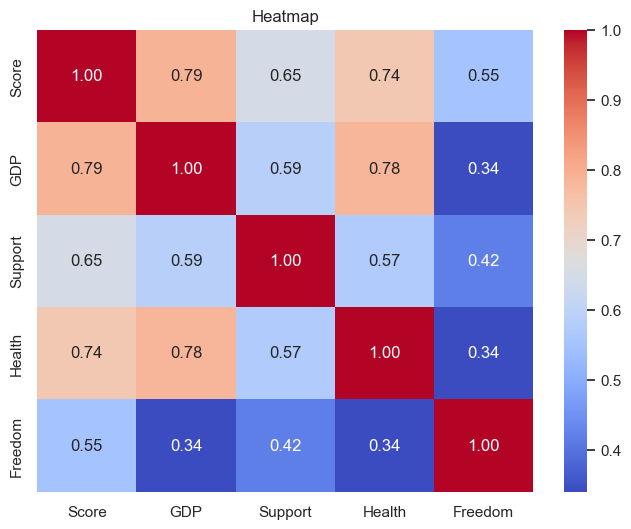

In [8]:

# EDA
# Heatmap showing correlation between features

# Correlation Ranking: 
# 1. GDP (0.79)
# 2. Health (0.74)
# 3. Support (0.65)
# 4. Freedom (0.55)

# If I am a president who want to increase the happiness score, 
# I would 
#   1. focus on improving economic conditions
#   2. expand healthcare systems

# numeric variables
vars = ['Score', 'GDP', 'Support', 'Health', 'Freedom']

# pearson correlation
corr = data[vars].corr(method='pearson')

# print correlation result
print("Correlation result: ")
print(corr)

# visualize heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap')
plt.show()

In [9]:
# features
features = ["GDP", "Support", "Health", "Freedom"]

# Modeling - training(2015-2018)
train = data[data["Year"].isin(["2015", "2016", "2017", "2018"])]
x_train = train[features]
y_train = train["Score"]

# Modeling - testing(2019)
test = data[data["Year"] == "2019"].copy()
x_test = test[features]
y_test = test["Score"]

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Ridge": Ridge(alpha=1.0)
}


In [14]:
# save result in a list
results = []

for name, model in models.items():

    # train model using data from 2015 to 2018
    model.fit(x_train, y_train)

    # predict happiness score in 2019
    y_pred = model.predict(x_test)

    # RSE calculation
    # Measure how different predictions and actual values
    err = y_test - y_pred
    rse = np.sqrt(np.mean(err ** 2))
    results.append((name, rse))

    # Save predicted scores and rankings
    test[f"{name} pred_score"] = y_pred
    test[f"{name} pred_rank"] = test[f"{name} pred_score"].rank(ascending=False)

test["Actual Rank"] = test["Score"].rank(ascending=False)

# Print RSE for each model
for name, rse in results:
    print(f"{name}'s RSE: {rse:.4f}")

Linear Regression's RSE: 0.5629
KNN Regressor's RSE: 0.5343
Ridge's RSE: 0.5637


In [11]:
# I tested three models: Linear regressor, KNN regressor, and Ridge regression
#   1. Linear regressor: fits a straight line
#   2. KNN regressor: averages nearby neighbors (n_neighbor=5)
#   3. Ridge regression: reduces big weights in order to avoid overfitting
# I observed that 'Ridge' has the most accurate average ranking difference (15.47), 
#   'Linear regressor' has the second most accurate average ranking difference (15.49),
#   and 'KNN' has the third most accurate average ranking difference (15.88). 

# Calculate ranking diff each model
test["linear_rank_diff"] = test["Actual Rank"] - test["Linear Regression pred_rank"]
test["KNN_rank_diff"] = test["Actual Rank"] - test["KNN Regressor pred_rank"]
test["ridge_rank_diff"] = test["Actual Rank"] - test["Ridge pred_rank"]

# print each ranking difference of each model
print("Average Ranking Difference of Each Model")
print(f"Linear Regression: {test["linear_rank_diff"].abs().mean():.2f}")
print(f"KNN Regressor: {test["KNN_rank_diff"].abs().mean():.2f}")
print(f"Ridge: {test["ridge_rank_diff"].abs().mean():.2f}")

Average Ranking Difference of Each Model
Linear Regression: 15.49
KNN Regressor: 15.88
Ridge: 15.47


In [12]:
# Custom formula using correlation:
# Inspired by the correlation between Score and features(GDP[0.789], Health[0.742], Support[0.649], and Freedom[0.551])
# 0.789 + 0.742 + 0.649 + 0.551 = 2.731
# 0.789/2.731 = 0.289
# 0.742/2.731 = 0.272
# 0.649/2.731 = 0.238
# 0.551/2.731 = 0.202
# custom_score = 0.289*[GDP] + 0.272*[Health] + 0.238*[Support] + 0.202*[Freedom]

# The result of applying custom happiness score: [15.57]
# better than KNN model and close to Linear and Ridge. 

# custom score
test["custom_score"] = (
    0.289 * test["GDP"]
    + 0.272 * test["Health"]
    + 0.238 * test["Support"]
    + 0.202 * test["Freedom"]
)

# custom rank (descending order)
test["custom_rank"] = test["custom_score"].rank(ascending=False)

# difference between custom and actual rank
test["custom_rank_diff"] = test["Actual Rank"] - test["custom_rank"]

# print custom_rank_diff
print("Custom Ranking vs. Actual Ranking: ")
print(f"The absolute value of the difference: {test["custom_rank_diff"].abs().mean():.2f}")


Custom Ranking vs. Actual Ranking: 
The absolute value of the difference: 15.57
